In [1]:
#Importation
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer

In [2]:
dataset=pd.read_csv("C:\\Users\\karel\\OneDrive\\Bureau\\ISEP1\\AUTRES ISEP1\\ML\\Projets\\Zindi_Fraude\\training.csv")
df=dataset.copy()
df=df.drop(['CurrencyCode', 'CountryCode'],axis=1)

#création de variables temporelles
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
df['DayOfWeek'] = df['TransactionStartTime'].dt.dayofweek
df['WeekOfYear'] = df['TransactionStartTime'].dt.isocalendar().week
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6])
df['Month'] = df['TransactionStartTime'].dt.month
df['Day'] = df['TransactionStartTime'].dt.day
df['Hour'] = df['TransactionStartTime'].dt.hour
df['Crénaux_horaire'] = pd.cut(df['Hour'], 
                       bins=[0, 6, 12, 18, 24], 
                       labels=['Nuit', 'Matin', 'Après-midi', 'Soir'])

#on crée des sous datasets des différentes catégories de la target
fraude=df[df['FraudResult']==1]
non_fraude=df[df['FraudResult']==0]

#créer des datasets selon les groupes des features
identifiants=df[['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId']]
info_produits_et_services=df[['ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId']]
valeurs_financières=df[['Amount', 'Value']]
startégie=df['PricingStrategy']
heure=df['Hour']
jour_sem=df['DayOfWeek']
jour_mois=df['Day']
Crénaux_horaire=df['Crénaux_horaire']
semaine_année=df['WeekOfYear']
mois=df['Month']


In [3]:
X=df.drop('FraudResult',axis=1)
y=df['FraudResult']
x_train, x_test, y_train, y_test=train_test_split(X,y, test_size=0.2)

In [4]:
from sklearn.preprocessing import TargetEncoder

num = make_column_selector(dtype_include='number')
cat = make_column_selector(dtype_exclude='number')
trans_num = make_pipeline(RobustScaler())
trans_cat = make_pipeline(TargetEncoder(), RobustScaler())
transformer = make_column_transformer((trans_num, num), (trans_cat, cat))
x_train_trans = transformer.fit_transform(x_train, y_train)  # Attention: y_train nécessaire
x_test_trans = transformer.transform(x_test)  # Utilisez transform, pas fit_transform

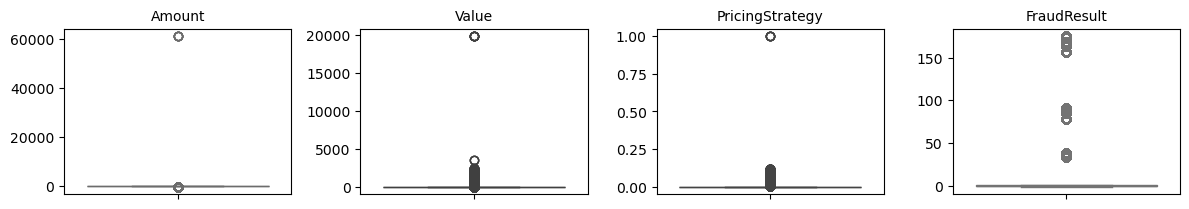

In [8]:
trainset = pd.concat([pd.DataFrame(x_train_trans), pd.DataFrame(y_train)], axis=1)
trainset.columns=df.columns
numeric_cols = ['Amount', 'Value', 'PricingStrategy', 'FraudResult']
palette = sns.color_palette("husl", len(numeric_cols))

# Calculer le nombre de colonnes par ligne
n_cols = len(numeric_cols)
cols_per_row = n_cols   # Arrondi vers le haut pour répartir équitablement

fig, axes = plt.subplots(2, cols_per_row, figsize=(3*cols_per_row, 4))
axes = axes.flatten()  # Convertir en array 1D pour faciliter l'indexation

for i, var in enumerate(numeric_cols):
    sns.boxplot(y=trainset[var], ax=axes[i], color=palette[i])
    axes[i].set_title(var, fontsize=10)
    axes[i].set_ylabel('')

# Masquer les axes non utilisés si le nombre de variables est impair
for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [20]:
trainset.columns=df.columns

In [ ]:
# Éviter la conversion DataFrame si possible
if hasattr(x_train_trans, 'columns'):
    # Si c'est déjà un DataFrame
    trainset = pd.concat([x_train_trans, y_train], axis=1)
else:
    # Conversion plus efficace
    trainset = pd.DataFrame(x_train_trans, columns=df.columns[:-1])
    trainset['FraudResult'] = y_train
trainset.columns=df.columns
# Sélectionner directement les colonnes d'intérêt
numeric_data = trainset[['Amount', 'Value', 'PricingStrategy', 'FraudResult']].sample(5000)

# Utiliser matplotlib au lieu de seaborn (plus rapide)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, col in enumerate(numeric_data.columns):
    numeric_data.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col)

In [ ]:
trainset = pd.concat([pd.DataFrame(x_train_trans), pd.DataFrame(y_train)], axis=1)
trainset.columns=df.columns
numeric_cols = trainset[['Amount', 'Value', 'PricingStrategy', 'FraudResult']]
palette = sns.color_palette("husl", len(numeric_cols))

fig, axes = plt.subplots(1, len(numeric_cols), figsize=(3*len(numeric_cols), 3))
for i, var in enumerate(numeric_cols):
    sns.boxplot(y=trainset[var], ax=axes[i], color=palette[i])
    axes[i].set_title(var, fontsize=10)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

## Modelling 1

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

In [11]:
model_1 = RandomForestClassifier(random_state=0)

In [12]:
model_2 = make_pipeline(PolynomialFeatures(2), SelectKBest(f_classif, k=10),
                      RandomForestClassifier(random_state=0))

## Procédure d'évaluation

In [13]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold, StratifiedKFold

In [20]:
def evaluation(model):
    
    model.fit(x_train_trans, y_train)
    ypred = model.predict(x_test_trans)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    cv=StratifiedKFold(4)
    N, train_score, val_score = learning_curve(model, x_train_trans, y_train,
                                              cv=cv, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
   
    plt.figure(figsize=(10, 6))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.xlabel('Taille de l\'échantillon')
    plt.ylabel('Score')
    plt.title('Courbes d\'apprentissage')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Figure 2 - Matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, ypred), 
               annot=True,        # affiche les valeurs dans les cellules
               cmap='Blues',      # palette de couleurs
               fmt='d',           # format des nombres (entiers)
               cbar=True)         # barre de couleur
    plt.title('Matrice de confusion')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.show()


[[19089     3]
 [    6    35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19092
           1       0.92      0.85      0.89        41

    accuracy                           1.00     19133
   macro avg       0.96      0.93      0.94     19133
weighted avg       1.00      1.00      1.00     19133



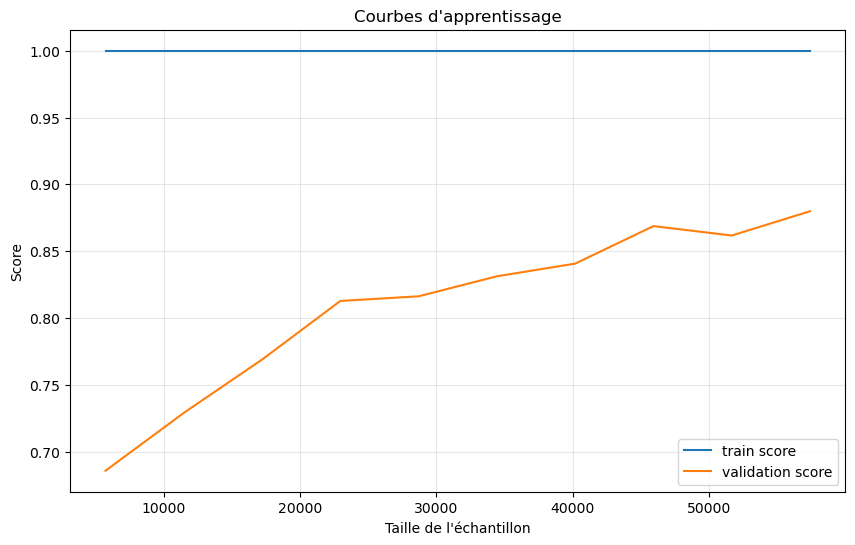

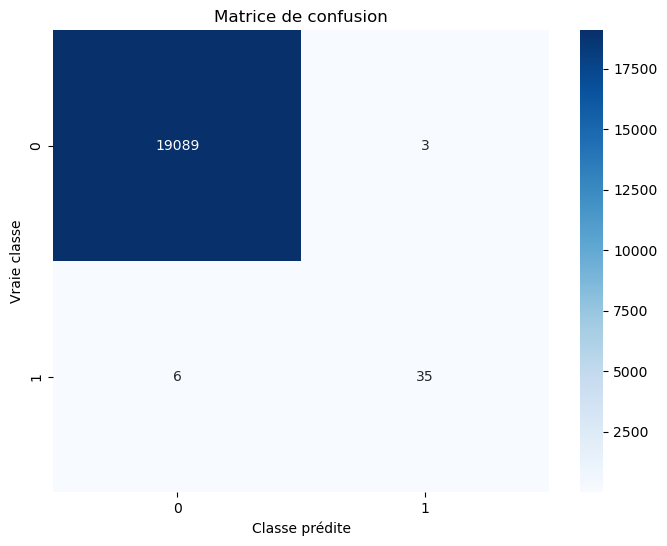

In [21]:
evaluation(model_1)

C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[[19089     3]
 [    8    33]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19092
           1       0.92      0.80      0.86        41

    accuracy                           1.00     19133
   macro avg       0.96      0.90      0.93     19133
weighted avg       1.00      1.00      1.00     19133



C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\karel\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\

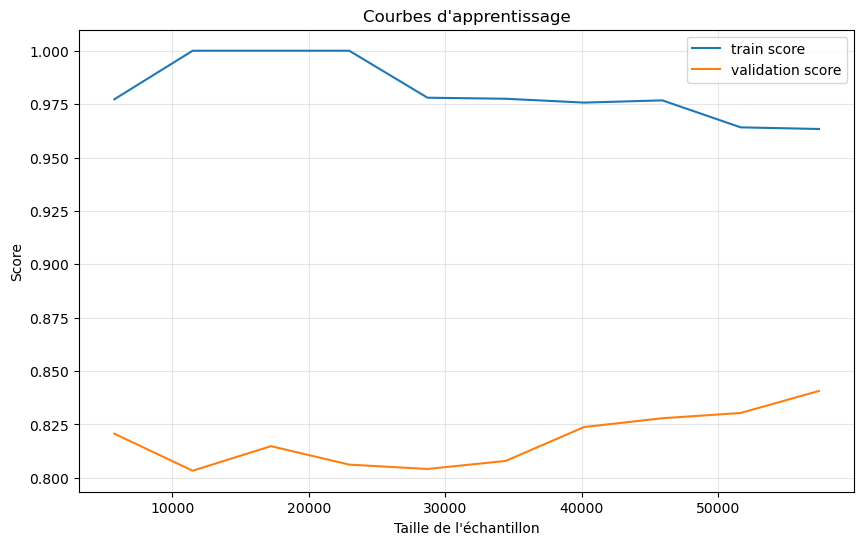

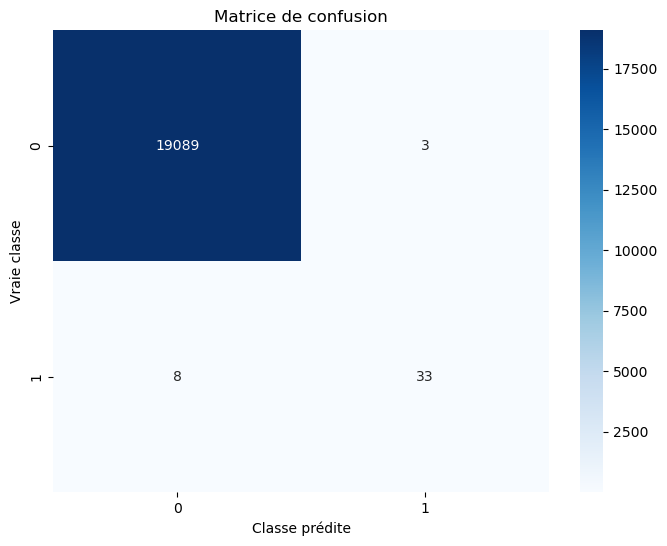

In [22]:
evaluation(model_2)

In [24]:
x_train_trans.dtype


dtype('float64')

<Axes: >

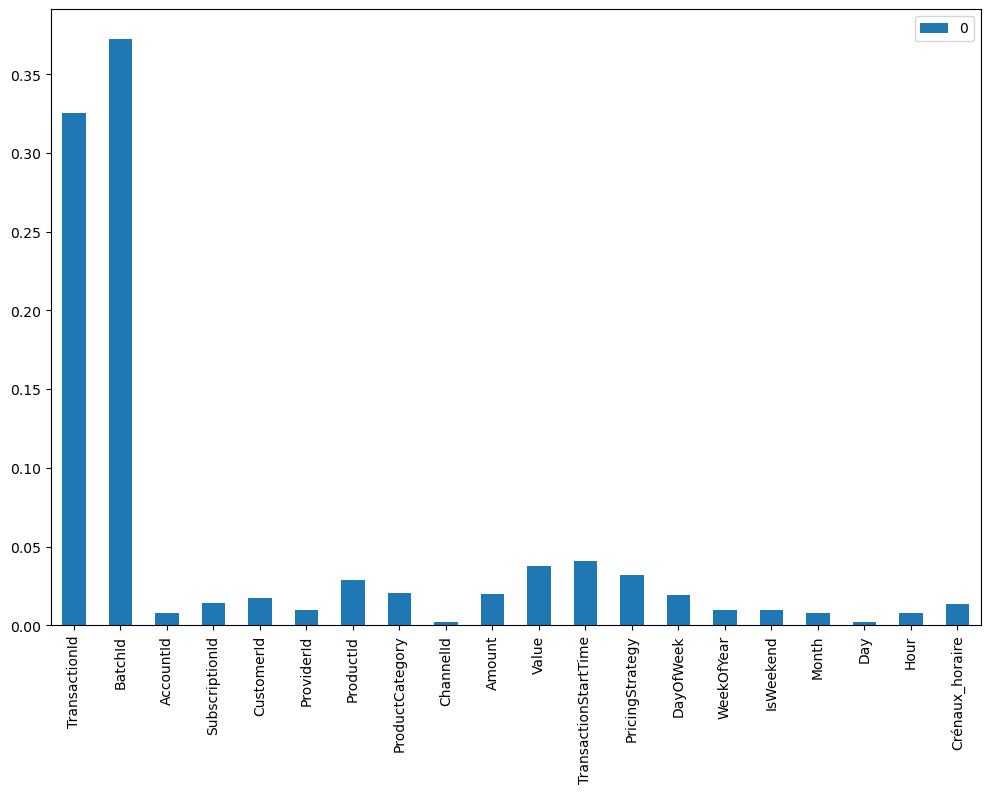

In [25]:
pd.DataFrame(model_1.feature_importances_, index=x_train.columns).plot.bar(figsize=(12, 8))